In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import json

Mounted at /content/gdrive


In [3]:
file = "TrainAndValid.csv"
df = pd.read_csv(file, parse_dates=["saledate"], low_memory=False)
print(df.shape)

(412698, 53)


The first thing to do is check how much of the data is missing, and what data types we have. We already know saledate is a datetime so we've handled that when loading the dataframe. 

I've already done some preliminary EDA and model interpretation with a random forest, so this workbook is going to approach the dataset from the perspective of knowing what the important columns are, but we need to make the data more conducive for creating a simple web app that will allow a user to easily predict the sale price of a piece of equipment.

In [4]:
nulls = df.isnull().sum().sort_values(ascending=False)
percent = nulls/df.shape[0]
null_types = df.dtypes
nulls_df = pd.DataFrame({"nulls":nulls, "percent": percent, "types": null_types})
nulls_df

,nulls,percent,types
Backhoe_Mounting,331986,0.804428,object
Blade_Extension,386715,0.937041,object
Blade_Type,330823,0.801610,object
Blade_Width,386715,0.937041,object
Coupler,192019,0.465277,object
Coupler_System,367724,0.891024,object
Differential_Type,341134,0.826595,object
Drive_System,305611,0.740520,object
Enclosure,334,0.000809,object
Enclosure_Type,386715,0.937041,object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


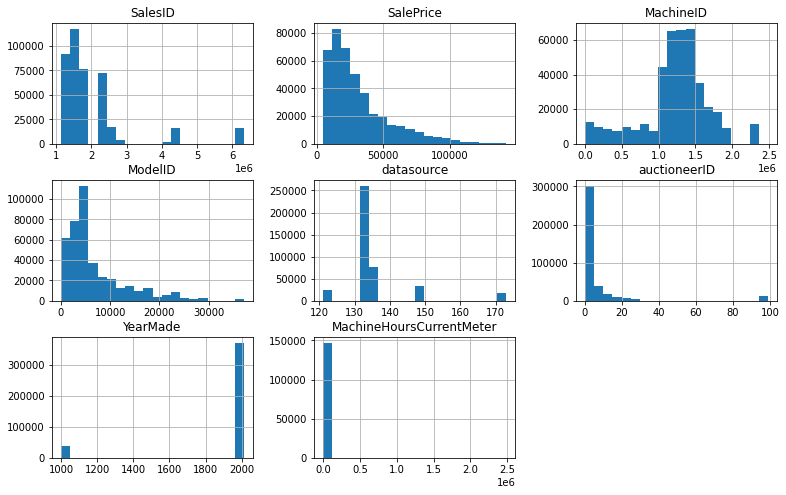

In [5]:
# quick plot of the numerical data to inspect it, and b/c there aren't a lot of
# numerical fields we just plot them all at once
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
df.hist(ax=ax, bins=20)
plt.show()

We can see there is an issue with YearMade, and besides SalePrice these other numerical fields aren't really continuous, plus there is very little missing numerical so we'll go ahead and fill the numerical data with the median value, at the same time we'll convert non-numerical data to categorical to help facilitate encoding everything later.

We'll also correct the issue with year made by converting everything older than 1950 to 1950.

Before that we'll copy the dataframe to a new variable and create new columns for saledate to parse out each aspect of the date into year, month, day, and day of year.

In [6]:
df_new = df.copy()
df_new.sort_values(by="saledate", ascending=True, inplace=True)
df_new["year"] = df_new["saledate"].dt.year
df_new["month"] = df_new["saledate"].dt.month
df_new["day"] = df_new["saledate"].dt.day
df_new["day_of_year"] = df_new["saledate"].dt.dayofyear
df_new.drop("saledate", axis=1, inplace=True)

df_new.loc[df_new["YearMade"] < 1950, "YearMade"] = 1950

# loop through columns to convert categorical and fill numerical fields as needed 
for label, content in df_new.items():
  # convert any string type fields to category type
  if pd.api.types.is_string_dtype(content):
    df_new[label] = content.astype("category").cat.as_ordered()
  
  # for any numerical fields with missing data, fill with the median value
  elif pd.api.types.is_numeric_dtype(content):
    if df_new[label].isnull().sum() > 0:
      df_new[label] = content.fillna(content.median())

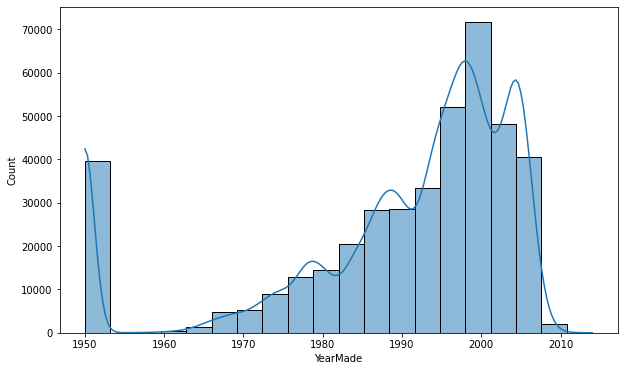

In [7]:
# lets check out the year made histogram again
plt.figure(figsize=(10, 6))
sns.histplot(df_new, x="YearMade", bins=20, kde=True)

Let's take a closer look at the categorical variables in the dataset. We want to see what is already there and how we might best fill the missing data in a way that will make an accurate model that is also easy for someone to use as a web app.

In [8]:
missing_values = []
non_numeric = []
categorize_dict = {}
for label, value in df_new.items():
  # create list of fields with missing values
  if df_new[label].isnull().sum() > 0:
    missing_values.append(label)
  
  # for categorical fields, add field name to list
  # add 1 to the codes, so missing values go from -1 to 0
  if not pd.api.types.is_numeric_dtype(value):
    non_numeric.append(label)
    categorize_dict[label] = list(pd.Categorical(value).categories)

print(missing_values)
print(non_numeric)
for k, v in categorize_dict.items():
  print(f"{k}({len(v)} items): {v}")
  if k in missing_values:
    print("  is missing values")
  if "None or Unspecified" in v:
    print("  contains 'None or Unspecified'")
  if "Unspecified" in v:
    print("  contains 'Unspecified'")

['UsageBand', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']
['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Rip

There are two big takeaways from this output: 1) there are a lot of fields that already have 'None or Unspecified' values that we could extend to fill missing values (so the end user wouldn't have to choose between that and 'N/A') and 2) some fields have high cardinality (i.e., they have a lot unique values). 'fiModelDesc' has over 5,000 different values, but it also looks like this model description can be parsed into 'fiBaseModel' and 'fiSecondaryDesc'. Let's print of some rows to get a better look at the actual data.

In [9]:
df_new.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,year,month,day,day_of_year
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,NaN,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,NaN,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,NaN,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,NaN,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,NaN,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,31
54653,1301884,23500.0,1182999,4123,132,99.0,1976,0.0,NaN,D6C,D6,C,NaN,NaN,Medium,"Track Type Tractor, Dozer - 130.0 to 160.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,31
81383,1379228,31000.0,1082797,7620,132,99.0,1986,0.0,NaN,IT12,IT12,NaN,NaN,NaN,Compact,Wheel Loader - 60.0 to 80.0 Horsepower,Florida,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31
204924,1645390,11750.0,1527216,8202,132,99.0,1970,0.0,NaN,544,544,NaN,NaN,NaN,NaN,Wheel Loader - 90.0 to 100.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31
135376,1493279,63000.0,1363756,2759,132,99.0,1987,0.0,NaN,D5HII,D5,H,II,NaN,Medium,"Track Type Tractor, Dozer - 130.0 to 160.0 Hor...",Florida,TTT,Track Type Tractors,NaN,EROPS,NaN,NaN,NaN,NaN,Powershift,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN,1989,

So not only does it look like 'fiModelDesc' can be parsed into 'fiBaseModel' and 'fiSecondaryDesc', but it looks like 'fiModelSeries' is part of it too. So, most likely we can have the user select a model from one of these options in the dataset (a dropdown list and auto-complete will be a must) and parse it into the sub-fields that we require in the final model. It also appears that if the sub-fields are not relevant for the model there are missing values. We are going to fill these with a generic placeholder 'n/a'. Because 'None or Unspecified' does not seem like it would be appropriate here, we are only going to use that for missing values if it already exists in the field, everything else will get 'n/a'.

We also see that 'fiProductClassDesc', 'ProductGroup', and 'ProductGroupDesc' are all closely related too. I think an option for the user to input 'ProductGroupDesc' and then select the relevant info to complete 'fiProductClassDesc' would be the best option.

Now lets fill the missing categorical values.

In [10]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df_new['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

for label, value in df_new.items():
  # for categorical fields, fill null values with "None or Unspecified"
  if not pd.api.types.is_numeric_dtype(value) and df_new[label].isnull().sum() > 0:
    if "None or Unspecified" in list(value.cat.categories):
      df_new[label] = value.fillna("None or Unspecified")
    else:
      value = value.cat.add_categories("n/a")
      df_new[label] = value.fillna("n/a")
print(f"Total null values = {df_new.isnull().sum().sum()}")
df_new.head()

Total null values = 0


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,year,month,day,day_of_year
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,n/a,TD20,TD20,n/a,n/a,n/a,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,n/a,OROPS,None or Unspecified,None or Unspecified,None or Unspecified,n/a,Direct Drive,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,Straight,None or Unspecified,n/a,n/a,1989,1,17,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,n/a,A66,A66,n/a,n/a,n/a,n/a,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,n/a,OROPS,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional,1989,1,31,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,n/a,D7G,D7,G,n/a,n/a,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,n/a,OROPS,None or Unspecified,None or Unspecified,None or Unspecified,n/a,Standard,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,Straight,None or Unspecified,n/a,n/a,1989,1,31,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,n/a,A62,A62,n/a,n/a,n/a,n/a,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,n/a,EROPS,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None or Unspecified,Standard,Conventional,1989,1,31,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,n/a,D3B,D3,B,n/a,n/a,n/a,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,n/a,OROPS,None or Unspecified,None or Unspecified,None or Unspecified,n/a,Standard,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,2 Valve,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,n/a,None or Unspecified,None or Unspecified,None

In [17]:
# TODO: mapping of the model options
df_model = df_new[["fiBaseModel", "fiSecondaryDesc", "fiModelSeries", "fiModelDescriptor"]]
model_dict = {}
for item in df_model.values:
  if item[0] not in model_dict.keys():
    model_dict[item[0]] = {"fiSecondaryDesc": [], "fiModelSeries": [],
                           "fiModelDescriptor": []}

  for key, value in zip(["fiSecondaryDesc", "fiModelSeries", "fiModelDescriptor"],
                        item[1:]):
    if value not in model_dict[item[0]][key]:
      model_dict[item[0]][key].append(value)
len(model_dict)

1961

In [16]:
model_dict["D3"]

{'fiModelDescriptor': ['n/a', 'LGP', 'XL', 'SLGP'],
 'fiModelSeries': ['n/a', 'II', 'III'],
 'fiSecondaryDesc': ['B', 'n/a', 'C', 'G', 'K']}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


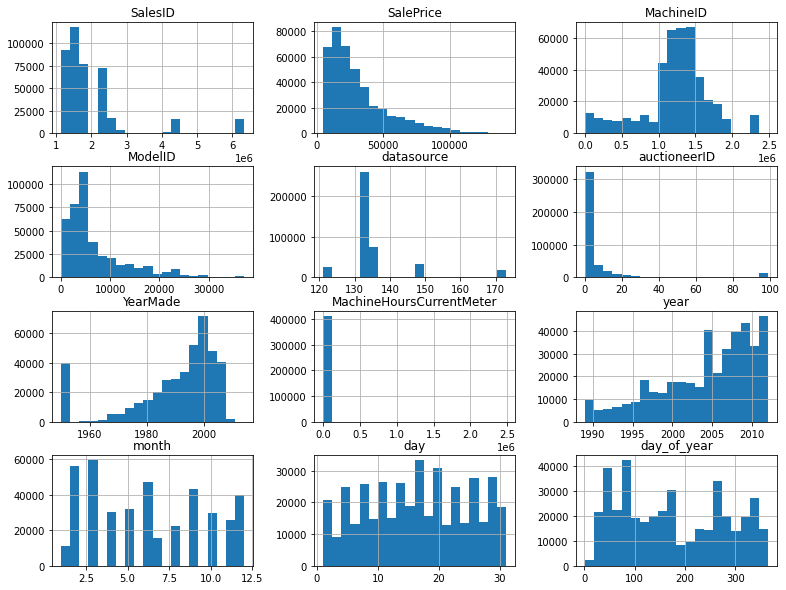

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
df_new.hist(ax=ax, bins=20)
plt.show()

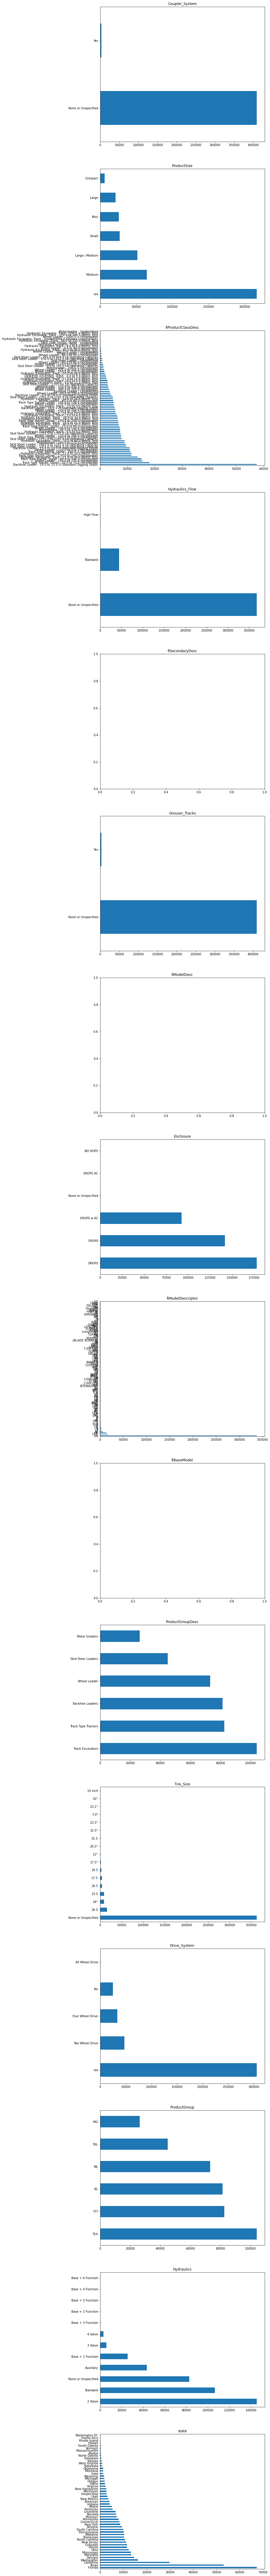

In [19]:
cat_columns = ["Coupler_System", "ProductSize", "fiProductClassDesc",
               "Hydraulics_Flow", "fiSecondaryDesc", "Grouser_Tracks",
               "fiModelDesc", "Enclosure", "fiModelDescriptor", "fiBaseModel",
               "ProductGroupDesc", "Tire_Size", "Drive_System", "ProductGroup",
               "Hydraulics", "state"]

fig, ax = plt.subplots(16, 1, figsize=(10, 160))
for i, col in enumerate(cat_columns):
  labels = df_new[col].cat.categories
  if len(labels) < 150:
    df_new[col].value_counts().plot.barh(ax=ax[i])
  # ax[i].set_yticks(range(len(labels)), labels)
  ax[i].set_title(col)

In [20]:
# to easily use the most important features, we'll likely need to have a
# simplified UI the parses or stitches the user input to create the features
# correctly for the model

The last step before saving the cleaned dataframe is to encode the categorical fields, this will make it easier for the machine learning model to use the dataset, but it will also make it a little harder to use and interpret the model. Therefore, we are going to create a dictionary of what variables are in each field before we encode the values. This way we can have a reference for later if we need to decode anything or encode new data when we want to predict on user input.

In [21]:
non_numeric = []
categorize_dict = {}
for label, value in df_new.items():
  # for categorical fields, add field name to list
  # add 1 to the codes, so missing values go from -1 to 0
  if not pd.api.types.is_numeric_dtype(value):
    non_numeric.append(label)
    categorize_dict[label] = list(pd.Categorical(value).categories)
    df_new[label] = pd.Categorical(value).codes

print(non_numeric)

['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']


In [22]:
categorize_dict["ProductSize"]

['Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact', 'n/a']

In [23]:
df_new.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                      int8
fiModelDesc                   int16
fiBaseModel                   int16
fiSecondaryDesc               int16
fiModelSeries                  int8
fiModelDescriptor             int16
ProductSize                    int8
fiProductClassDesc             int8
state                          int8
ProductGroup                   int8
ProductGroupDesc               int8
Drive_System                   int8
Enclosure                      int8
Forks                          int8
Pad_Type                       int8
Ride_Control                   int8
Stick                          int8
Transmission                   int8
Turbocharged                   int8
Blade_Extension             

In [24]:
df_new.to_csv("train_valid_cleaned_app.csv")

In [26]:
with open("bfb_categorizer_app.json", "w") as fout:
  json.dump(categorize_dict, fout, indent=4)

In [28]:
with open("bfb_model_dict_app.json", "w") as fout:
  json.dump(model_dict, fout, indent=4)